# 기본 설정

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# EDA

**ERROR**

In [ ]:
import pandas as pd

news_dataset_train = pd.read_csv("/gdrive/My Drive/한양대학교/NH투자증권 빅데이터 경진대회/data/news_train.csv")
del news_dataset_train["n_id"]
del news_dataset_train["date"]
del news_dataset_train["title"]
del news_dataset_train["ord"]

news_dataset_train = news_dataset_train.drop_duplicates()

news_dataset_train = news_dataset_train.groupby("content").size()

news_dataset_train = pd.DataFrame(news_dataset_train)

news_dataset_train = news_dataset_train.reset_index()

print(news_dataset_train[news_dataset_train[0]!=1])

                               content  0
15886                   데이터에서 찾은 AI 속보  2
25031    씨에스윈드, 193억 원 규모 윈드타워 공급계약 체결  2
25032  씨에스윈드, 1분기 영업이익 158억 원전년비 16.1%  2


In [ ]:
import pandas as pd

news_dataset_train = pd.read_csv("/gdrive/My Drive/한양대학교/NH투자증권 빅데이터 경진대회/data/news_train.csv")
del news_dataset_train["n_id"]
del news_dataset_train["date"]
del news_dataset_train["title"]
del news_dataset_train["ord"]

news_dataset_train = news_dataset_train.drop_duplicates()

print(news_dataset_train[news_dataset_train["content"]=="데이터에서 찾은 AI 속보"])
print(news_dataset_train[news_dataset_train["content"]=="씨에스윈드, 193억 원 규모 윈드타워 공급계약 체결"])
print(news_dataset_train[news_dataset_train["content"]=="씨에스윈드, 1분기 영업이익 158억 원전년비 16.1%"])

              content  info
35935  데이터에서 찾은 AI 속보     0
43736  데이터에서 찾은 AI 속보     1
                             content  info
50768  씨에스윈드, 193억 원 규모 윈드타워 공급계약 체결     0
50772  씨에스윈드, 193억 원 규모 윈드타워 공급계약 체결     1
                               content  info
50754  씨에스윈드, 1분기 영업이익 158억 원전년비 16.1%     0
50774  씨에스윈드, 1분기 영업이익 158억 원전년비 16.1%     1


**Baeseline**

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

news_dataset_test = pd.read_csv("/gdrive/My Drive/한양대학교/NH투자증권 빅데이터 경진대회/data/news_test.csv")
del news_dataset_test["n_id"]
del news_dataset_test["date"]
del news_dataset_test["title"]
del news_dataset_test["ord"]

news_dataset_test["info"] = np.nan

news_dataset_train = pd.read_csv("/gdrive/My Drive/한양대학교/NH투자증권 빅데이터 경진대회/data/news_train.csv")
del news_dataset_train["n_id"]
del news_dataset_train["date"]
del news_dataset_train["title"]
del news_dataset_train["ord"]
news_dataset_train = news_dataset_train[news_dataset_train["content"]!="데이터에서 찾은 AI 속보"]
news_dataset_train = news_dataset_train[news_dataset_train["content"]!="씨에스윈드, 193억 원 규모 윈드타워 공급계약 체결"]
news_dataset_train = news_dataset_train[news_dataset_train["content"]!="씨에스윈드, 1분기 영업이익 158억 원전년비 16.1%"]
news_dataset_train = news_dataset_train.drop_duplicates()

news_dataset_train = pd.DataFrame(news_dataset_train)

for i in tqdm(range(len(news_dataset_test))):
    if len(news_dataset_train[news_dataset_train["content"]==news_dataset_test.iloc[i,0]]) != 0:
        news_dataset_test.iloc[i,2] = int(news_dataset_train[news_dataset_train["content"]==news_dataset_test.iloc[i,0]]["info"])

print(news_dataset_test.groupby("info").size())

100%|██████████| 142565/142565 [12:06<00:00, 196.16it/s]

info
0.0     8379
1.0    45715
dtype: int64


**중복 제거 전**

info
0    71785
1    46864
dtype: int64
문장의 개수 : 118649문장
문장의 최대 길이 : 3469글자
문장의 평균 길이 : 51글자


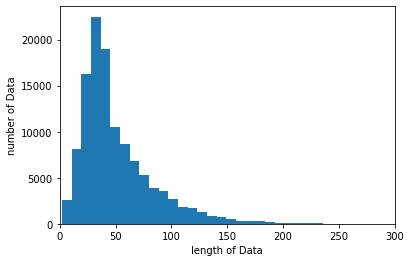

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

news_dataset_path = r"/gdrive/My Drive/한양대학교/NH투자증권 빅데이터 경진대회/data/news_train.csv"

news_dataset = pd.read_csv(news_dataset_path)

news_dataset = news_dataset[news_dataset["content"]!="데이터에서 찾은 AI 속보"]
news_dataset = news_dataset[news_dataset["content"]!="씨에스윈드, 193억 원 규모 윈드타워 공급계약 체결"]
news_dataset = news_dataset[news_dataset["content"]!="씨에스윈드, 1분기 영업이익 158억 원전년비 16.1%"]

del news_dataset["n_id"]
del news_dataset["date"]
del news_dataset["title"]
del news_dataset["ord"]

print(news_dataset.groupby(news_dataset["info"]).size())
print('문장의 개수 :', str(len(news_dataset))+'문장')
print('문장의 최대 길이 :', str(max(len(l) for l in news_dataset['content']))+'글자')
print('문장의 평균 길이 :', str(round(sum(map(len, news_dataset['content'])) / len(news_dataset['content'])))+'글자')

plt.hist([len(s) for s in news_dataset['content']], bins=400)
plt.xlim(0,300)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

**중복 제거 후**

info
0    40367
1     5791
dtype: int64
문장의 개수 : 46158문장
문장의 최대 길이 : 3469글자
문장의 평균 길이 : 63글자


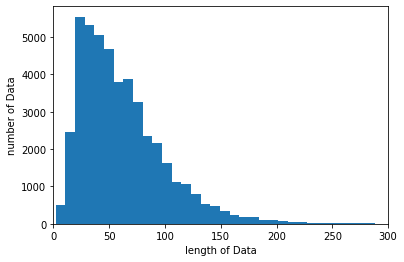

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

news_dataset_path = r"/gdrive/My Drive/한양대학교/NH투자증권 빅데이터 경진대회/data/news_train.csv"

news_dataset = pd.read_csv(news_dataset_path)

news_dataset = news_dataset[news_dataset["content"]!="데이터에서 찾은 AI 속보"]
news_dataset = news_dataset[news_dataset["content"]!="씨에스윈드, 193억 원 규모 윈드타워 공급계약 체결"]
news_dataset = news_dataset[news_dataset["content"]!="씨에스윈드, 1분기 영업이익 158억 원전년비 16.1%"]

del news_dataset["n_id"]
del news_dataset["date"]
del news_dataset["title"]
del news_dataset["ord"]

news_dataset = news_dataset.drop_duplicates()

print(news_dataset.groupby(news_dataset["info"]).size())
print('문장의 개수 :', str(len(news_dataset))+'문장')
print('문장의 최대 길이 :', str(max(len(l) for l in news_dataset['content']))+'글자')
print('문장의 평균 길이 :', str(round(sum(map(len, news_dataset['content'])) / len(news_dataset['content'])))+'글자')

plt.hist([len(s) for s in news_dataset['content']], bins=400)
plt.xlim(0,300)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

**Length**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

news_dataset_path = r"/gdrive/My Drive/한양대학교/NH투자증권 빅데이터 경진대회/data/news_train.csv"

news_dataset = pd.read_csv(news_dataset_path)

news_dataset = news_dataset[news_dataset["content"]!="데이터에서 찾은 AI 속보"]
news_dataset = news_dataset[news_dataset["content"]!="씨에스윈드, 193억 원 규모 윈드타워 공급계약 체결"]
news_dataset = news_dataset[news_dataset["content"]!="씨에스윈드, 1분기 영업이익 158억 원전년비 16.1%"]

del news_dataset["n_id"]
del news_dataset["date"]
del news_dataset["title"]
del news_dataset["ord"]

news_dataset = news_dataset.drop_duplicates()

news_dataset["len"] = news_dataset["content"].apply(lambda x : len(x))

**title + content**

info
0    45385
1    25501
dtype: int64
문장의 개수 : 70886문장
문장의 최대 길이 : 3490글자
문장의 평균 길이 : 85글자


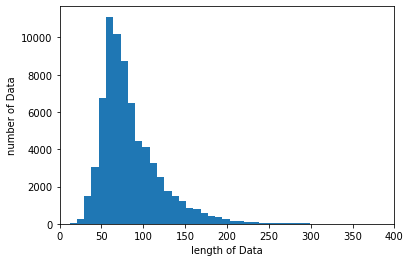

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

news_dataset_path = r"/gdrive/My Drive/한양대학교/NH투자증권 빅데이터 경진대회/data/news_train.csv"

news_dataset = pd.read_csv(news_dataset_path)

news_dataset = news_dataset[news_dataset["content"]!="데이터에서 찾은 AI 속보"]
news_dataset = news_dataset[news_dataset["content"]!="씨에스윈드, 193억 원 규모 윈드타워 공급계약 체결"]
news_dataset = news_dataset[news_dataset["content"]!="씨에스윈드, 1분기 영업이익 158억 원전년비 16.1%"]

news_dataset["content"] = news_dataset["title"] + " " + news_dataset["content"]

del news_dataset["n_id"]
del news_dataset["date"]
del news_dataset["title"]
del news_dataset["ord"]

news_dataset = news_dataset.drop_duplicates()

print(news_dataset.groupby(news_dataset["info"]).size())
print('문장의 개수 :', str(len(news_dataset))+'문장')
print('문장의 최대 길이 :', str(max(len(l) for l in news_dataset['content']))+'글자')
print('문장의 평균 길이 :', str(round(sum(map(len, news_dataset['content'])) / len(news_dataset['content'])))+'글자')

plt.hist([len(s) for s in news_dataset['content']], bins=400)
plt.xlim(0,400)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

# Data Preprocessing

In [1]:
max_len = 100

In [2]:
import pandas as pd
import re
import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder; LE = LabelEncoder()
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE

def convert_to_ord(data):
    try:
        return [ord(xx) for xx in data]
    except:
        print(data)

news_dataset_path = r"/gdrive/My Drive/한양대학교/NH투자증권 빅데이터 경진대회/data/news_train.csv"

news_dataset = pd.read_csv(news_dataset_path)

news_dataset = news_dataset[news_dataset["content"]!="데이터에서 찾은 AI 속보"]
news_dataset = news_dataset[news_dataset["content"]!="씨에스윈드, 193억 원 규모 윈드타워 공급계약 체결"]
news_dataset = news_dataset[news_dataset["content"]!="씨에스윈드, 1분기 영업이익 158억 원전년비 16.1%"]

#news_dataset["content"] = news_dataset["title"] + " " + news_dataset["content"]

del news_dataset["n_id"]
del news_dataset["date"]
del news_dataset["title"]
del news_dataset["ord"]

news_dataset_0 = news_dataset[news_dataset["info"]==0]

#news_dataset_0 = pd.DataFrame(news_dataset_0.groupby("content").size())

#news_dataset_0 = news_dataset_0.reset_index()

#news_dataset_0.columns = ["content", "info"]

#news_dataset_0 = news_dataset_0[news_dataset_0["info"]==1]

#news_dataset_0["info"] = 0

news_dataset_0 = news_dataset_0.drop_duplicates()

news_dataset_0 = news_dataset_0.sample(n=40367)

news_dataset_1 = news_dataset[news_dataset["info"]==1]

news_dataset = pd.concat([news_dataset_0,news_dataset_1])

#news_dataset = news_dataset.drop_duplicates()

#news_dataset["content"] = news_dataset["content"].apply(lambda x : ' '.join(re.sub(r'[^0-9a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣]', ' ', x.strip()).split()))

print(news_dataset.groupby("info").size())

news_dataset['content'] = news_dataset['content'].map(convert_to_ord)
news_dataset['info'] = LE.fit_transform(news_dataset['info'])

data = sequence.pad_sequences(news_dataset['content'], maxlen=max_len)

x_train = data
y_train = news_dataset['info']

#x_train, x_test, y_train, y_test = train_test_split(data, news_dataset['info'], test_size=0.1, random_state=42)

#sm = SMOTE(random_state=42)
#x_train, y_train = sm.fit_resample(x_train, y_train)

#y_true = copy.deepcopy(y_test)
y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)

print('train_shape : {} / {}'.format(x_train.shape, y_train.shape))
#print('test_shape : {} / {}'.format(x_test.shape, y_test.shape))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


info
0    40367
1    46864
dtype: int64
train_shape : (87231, 100) / (87231, 2)


# MODEL

**Hyperparameter**

In [3]:
output_dim = 200
filters = 400
filter_sizes = [2, 3, 4, 5]
epochs = 2**10
batch_size = 2**10

**CNN**

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, concatenate, Embedding, Reshape, Flatten, Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def convolution():
    inn = Input(shape = (max_len, output_dim, 1))
    convolutions = []
    for fs in filter_sizes:
        conv = Conv2D(filters = filters, kernel_size = (fs, output_dim), strides = 1, padding = "valid")(inn)
        nonlinearity = Activation('relu')(conv)
        maxpool = MaxPooling2D(pool_size = (max_len - fs + 1, 1), padding = "valid")(nonlinearity)
        convolutions.append(maxpool)
    outt = concatenate(convolutions)
    model = Model(inputs = inn, outputs = outt)
    return model

def conv2d_cnn():
    model = Sequential()
    model.add(Embedding(input_dim=2**16, output_dim=output_dim, input_length=max_len))
    model.add(Reshape((max_len, output_dim, 1), input_shape=(max_len, output_dim)))
    model.add(convolution())
    model.add(Flatten())

    model.add(Dense(2**8))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Dense(2**8))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Dense(2**8))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Dense(2))
    model.add(Activation('softmax'))
    adam = optimizers.Adam(lr=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.summary()
    early_stopping = EarlyStopping(monitor="val_loss", patience=10)
    modelcheckpoint = ModelCheckpoint('/gdrive/My Drive/한양대학교/NH투자증권 빅데이터 경진대회/model/news_model.h5', monitor='val_loss', mode='min', save_best_only=True)
    history = model.fit(x_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping,modelcheckpoint])

    return model, history

if __name__ == "__main__":

    with tf.device('/device:GPU:0'):
        model, history = conv2d_cnn()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 200)          13107200  
_________________________________________________________________
reshape (Reshape)            (None, 100, 200, 1)       0         
_________________________________________________________________
functional_1 (Functional)    (None, 1, 1, 1600)        1121600   
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               409856    
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

**RNN/LSTM**

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation, Bidirectional
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def bilstm():
    model = Sequential()
    model.add(Bidirectional(LSTM(2 ** 6, return_sequences=True), input_shape=(max_len, 1)))
    model.add(Bidirectional(LSTM(2 ** 6, return_sequences=True)))
    model.add(Bidirectional(LSTM(2 ** 6, return_sequences=False)))

    model.add(Dense(2))
    model.add(Activation('softmax'))
    adam = optimizers.Adam(lr=0.00001)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.summary()
    early_stopping = EarlyStopping(monitor="val_loss", patience=10)
    modelcheckpoint = ModelCheckpoint('/gdrive/My Drive/한양대학교/NH투자증권 빅데이터 경진대회/model/news_model.h5', monitor='val_loss', mode='min', save_best_only=True)
    history = model.fit(x_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping,modelcheckpoint])

    return model, history

if __name__ == "__main__":
    x_train = np.array(x_train).reshape((x_train.shape[0], x_train.shape[1], 1))
    x_test = np.array(x_test).reshape((x_test.shape[0], x_test.shape[1], 1))

    model, history = bilstm()

**Graph**

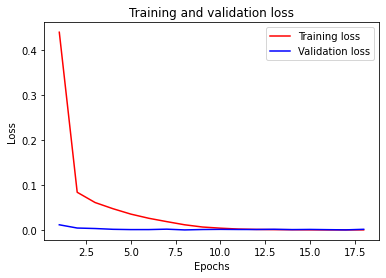

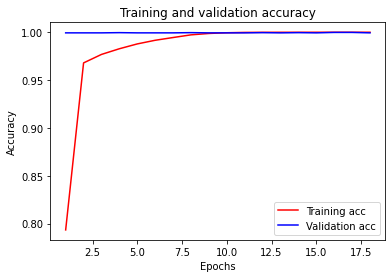

In [5]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.figure()
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**TEST**

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

model = load_model('/gdrive/My Drive/한양대학교/NH투자증권 빅데이터 경진대회/model/news_model.h5')

scores = model.evaluate(x_test, y_test)
print(scores)
print("정확도: %.2f%%" % (scores[1] * 100))

y_true = list(y_true)
y_pred = model.predict_classes(x_test)
y_pred = list(y_pred)

print(classification_report(y_true, y_pred))
print(pd.crosstab(pd.Series(y_true), pd.Series(y_pred), rownames=['True'], colnames=['Predicted']))

# RESULT

In [6]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import load_model

def convert_to_ord(data):
    try:
        return [ord(xx) for xx in data]
    except:
        print(data)

news_dataset_test = pd.read_csv("/gdrive/My Drive/한양대학교/NH투자증권 빅데이터 경진대회/data/news_test.csv")

#news_dataset_test["content"] = news_dataset_test["title"] + " " + news_dataset_test["content"]

del news_dataset_test["n_id"]
del news_dataset_test["date"]
del news_dataset_test["title"]
del news_dataset_test["ord"]

model = load_model('/gdrive/My Drive/한양대학교/NH투자증권 빅데이터 경진대회/model/news_model.h5')

x_test = sequence.pad_sequences(news_dataset_test['content'].map(convert_to_ord), maxlen=max_len)

news_dataset_test["info"] = model.predict_classes(x_test)

print(news_dataset_test.groupby("info").size())

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
info
0    87633
1    54932
dtype: int64


In [7]:
news_dataset_test_1 = pd.read_csv("/gdrive/My Drive/한양대학교/NH투자증권 빅데이터 경진대회/data/news_test.csv")

news_dataset_test["content"] = news_dataset_test_1["content"]

In [8]:
from tqdm import tqdm

news_dataset_train = pd.read_csv("/gdrive/My Drive/한양대학교/NH투자증권 빅데이터 경진대회/data/news_train.csv")
del news_dataset_train["n_id"]
del news_dataset_train["date"]
del news_dataset_train["title"]
del news_dataset_train["ord"]
news_dataset_train = news_dataset_train[news_dataset_train["content"]!="데이터에서 찾은 AI 속보"]
news_dataset_train = news_dataset_train[news_dataset_train["content"]!="씨에스윈드, 193억 원 규모 윈드타워 공급계약 체결"]
news_dataset_train = news_dataset_train[news_dataset_train["content"]!="씨에스윈드, 1분기 영업이익 158억 원전년비 16.1%"]
news_dataset_train = news_dataset_train.drop_duplicates()

news_dataset_train = pd.DataFrame(news_dataset_train)

for i in tqdm(range(len(news_dataset_test))):
    if len(news_dataset_train[news_dataset_train["content"]==news_dataset_test.iloc[i,0]]) != 0:
        news_dataset_test.iloc[i,2] = int(news_dataset_train[news_dataset_train["content"]==news_dataset_test.iloc[i,0]]["info"])

print(news_dataset_test.groupby("info").size())

100%|██████████| 142565/142565 [11:55<00:00, 199.20it/s]

info
0    87628
1    54937
dtype: int64


In [9]:
def g(x):
    if x["content"] == "데이터에서 찾은 AI 속보":
        return 1
    else:
        return x["info"]

news_dataset_test["info"] = news_dataset_test.apply(g, axis=1)

print(news_dataset_test.groupby("info").size())

info
0    87408
1    55157
dtype: int64


In [10]:
news_dataset_test = news_dataset_test[["id","info"]]

news_dataset_test.to_csv("/gdrive/My Drive/한양대학교/NH투자증권 빅데이터 경진대회/result/sample_submission.csv", index=False)